In [37]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

from utils import read_line_number, extract_args

In [38]:
from reader.BaseReader import worker_init_func
from task.TopK import init_ranking_report, calculate_ranking_metric

def get_userwise_group(model, group_feature, fairness_control):
    eval_data = model.reader.get_eval_dataset()
    eval_loader = DataLoader(eval_data, worker_init_fn = worker_init_func,
                             batch_size = 1, shuffle = False, pin_memory = False, 
                             num_workers = eval_data.n_worker)
    user_groups = {}
    with torch.no_grad():
        for i, batch_data in enumerate(eval_loader):
            # sample user with record in eval data
            if "no_item" not in batch_data:
                # predict
                feed_dict = model.wrap_batch(batch_data)
                uid = feed_dict["user_UserID"].reshape(-1).detach().cpu().numpy()[0]
                user_groups[uid] = fairness_control.group_dict[uid]
    return user_groups

def get_userwise_performance(model, at_k_list, phase = 'test'):
    model.reader.set_phase(phase)
    eval_data = model.reader.get_eval_dataset()
    eval_loader = DataLoader(eval_data, worker_init_fn = worker_init_func,
                             batch_size = 1, shuffle = False, pin_memory = False, 
                             num_workers = eval_data.n_worker)
    user_results = {}
    with torch.no_grad():
        for i, batch_data in enumerate(eval_loader):
            # sample user with record in eval data
            if "no_item" not in batch_data:
                # predict
                feed_dict = model.wrap_batch(batch_data)
                out_dict = model.forward(feed_dict, return_prob = True)
                pos_preds, neg_preds = out_dict["probs"], out_dict["neg_probs"]
                if pos_preds.is_cuda:
                    pos_preds = pos_preds.detach().cpu()
                    neg_preds = neg_preds.detach().cpu()
                # metrics
                report = init_ranking_report(at_k_list)
                calculate_ranking_metric(pos_preds.view(-1), neg_preds.view(-1), at_k_list, report)
                uid = feed_dict["user_UserID"].reshape(-1).detach().cpu().numpy()[0]
                user_results[uid] = report
    return user_results

In [39]:
from reader.RecDataReader import RecDataReader
from model.fair_rec.FairUserGroupPerformance import FairUserGroupPerformance
from model.baselines import *
from model.fed_rec import *
import os
import torch

model_name_list = {'MF': 'MF', 'FedMF': 'FedMF', 'FairMF': 'MF', 'F2MF': 'FedMF'}
device = -1
if device >= 0 and torch.cuda.is_available():
    os.environ["CUDA_VISIBLE_DEVICES"] = str(device)
    torch.cuda.set_device(device)
    device = "cuda:" + str(device)
else:
    device = "cpu"
# params = {'at_k_list': [10,50], 'eval_sample_p': 1.0}

In [40]:
import numpy as np
from reader.RecDataReader import sample_negative
class EvalDataReader(RecDataReader):
    def get_user_feed_dict(self, uid, phase, n_neg = -1):
        if len(self.user_hist[uid]) == 0:
            return {"no_item": True}
        items, responses, times = zip(*self.user_hist[uid])
        start, end = self.pos_range[phase][uid]
        neg_items = sample_negative([self.get_item_feature(iid, "ItemID") for iid in items], self.n_items, n_neg = n_neg)
        items = items[start:end]
        user_data = {"resp": np.array(responses[start:end])}
        for k,v in self.get_user_meta(uid).items():
            user_data["user_" + k] = np.array(v)
        if len(items) > 0:
            for k,v in self.get_item_list_meta(items).items():
                user_data["item_" + k] = np.array(v)
            for k,v in self.get_item_list_meta(neg_items, from_idx = True).items():
                user_data["negi_" + k] = np.array(v)
        else:
            user_data["no_item"] = True
        return user_data

## Do Fairness Evaluation

In [65]:
group_feature = 'activity'
phase = 'test'
modelName = 'FairMF'

data_key = 'ml-1m'
# data_key = 'amz_Movies_and_TV'
# data_key = 'amz_Books'

from data.preprocess import ROOT
best_setting = {
    'ml-1m': {
        'MF': [
#             '/logs/f2rec_train_and_eval_MF_lr0.0001_reg0.1_losspairwisebpr.log'
        ], 
        'FedMF': [
#             '/logs/f2rec_train_and_eval_FedMF_lr0.003_reg0.1_losspairwisebpr_local1_fedavg.log'
        ], 
        'FairMF': [
            f'/logs/f2rec_train_and_eval_FairMF_lr0.00003_reg0.1_losspairwisebpr_lambda-0.7_g{group_feature}.log'
            ,f'/logs/f2rec_train_and_eval_FairMF_lr0.00003_reg0.1_losspairwisebpr_lambda-0.5_g{group_feature}.log'
            ,f'/logs/f2rec_train_and_eval_FairMF_lr0.00003_reg0.1_losspairwisebpr_lambda-0.3_g{group_feature}.log'
            ,f'/logs/f2rec_train_and_eval_FairMF_lr0.00003_reg0.1_losspairwisebpr_lambda-0.1_g{group_feature}.log'
            ,f'/logs/f2rec_train_and_eval_FairMF_lr0.00003_reg0.1_losspairwisebpr_lambda0.1_g{group_feature}.log'
            ,f'/logs/f2rec_train_and_eval_FairMF_lr0.00003_reg0.1_losspairwisebpr_lambda0.3_g{group_feature}.log'
            ,f'/logs/f2rec_train_and_eval_FairMF_lr0.00003_reg0.1_losspairwisebpr_lambda0.5_g{group_feature}.log'
            ,f'/logs/f2rec_train_and_eval_FairMF_lr0.00003_reg0.1_losspairwisebpr_lambda0.7_g{group_feature}.log'
            ,f'/logs/f2rec_train_and_eval_FairMF_lr0.00003_reg0.1_losspairwisebpr_lambda0.9_g{group_feature}.log'
        ],
        'F2MF': [
            f'/logs/f2rec_train_and_eval_FairFedMF_lr0.003_reg0.1_losspairwisebpr_lambda-0.7_sigma0_g{group_feature}.log'
            ,f'/logs/f2rec_train_and_eval_FairFedMF_lr0.003_reg0.1_losspairwisebpr_lambda-0.5_sigma0_g{group_feature}.log'
            ,f'/logs/f2rec_train_and_eval_FairFedMF_lr0.003_reg0.1_losspairwisebpr_lambda-0.3_sigma0_g{group_feature}.log'
            ,f'/logs/f2rec_train_and_eval_FairFedMF_lr0.003_reg0.1_losspairwisebpr_lambda-0.1_sigma0_g{group_feature}.log'
            ,f'/logs/f2rec_train_and_eval_FairFedMF_lr0.003_reg0.1_losspairwisebpr_lambda0.1_sigma0_g{group_feature}.log'
            ,f'/logs/f2rec_train_and_eval_FairFedMF_lr0.003_reg0.1_losspairwisebpr_lambda0.3_sigma0_g{group_feature}.log'
            ,f'/logs/f2rec_train_and_eval_FairFedMF_lr0.003_reg0.1_losspairwisebpr_lambda0.5_sigma0_g{group_feature}.log'
            ,f'/logs/f2rec_train_and_eval_FairFedMF_lr0.003_reg0.1_losspairwisebpr_lambda0.7_sigma0_g{group_feature}.log'
            ,f'/logs/f2rec_train_and_eval_FairFedMF_lr0.003_reg0.1_losspairwisebpr_lambda0.9_sigma0_g{group_feature}.log'
        ]
    },
    'amz_Books': {
        'MF': [
                '/logs/f2rec_train_and_eval_MF_lr0.00001_reg1.0_losspairwisebpr.log'
        ], 
        'FedMF': [],
        'FairMF': [
            '/logs/f2rec_train_and_eval_FairMF_lr0.00001_reg1.0_losspairwisebpr_lambda-0.1_gactivity.log'
            ,'/logs/f2rec_train_and_eval_FairMF_lr0.00001_reg1.0_losspairwisebpr_lambda0_gactivity.log'
            ,'/logs/f2rec_train_and_eval_FairMF_lr0.00001_reg1.0_losspairwisebpr_lambda0.1_gactivity.log'
            ,'/logs/f2rec_train_and_eval_FairMF_lr0.00001_reg1.0_losspairwisebpr_lambda1.0_gactivity.log'
        ],
        'F2MF': []
    },
    'amz_Movies_and_TV': {
        'MF': [
            '/logs/f2rec_train_and_eval_MF_lr0.00003_reg1.0_losspairwisebpr.log'
        ], 
        'FedMF': [
            '/logs/f2rec_train_and_eval_FedMF_lr0.003_reg1.0_losspairwisebpr_local1_fedavg.log'
        ], 
        'FairMF': [
            '/logs/f2rec_train_and_eval_FairMF_lr0.00001_reg1.0_losspairwisebpr_lambda-0.1_gactivity.log'
            ,'/logs/f2rec_train_and_eval_FairMF_lr0.00001_reg1.0_losspairwisebpr_lambda0_gactivity.log'
            ,'/logs/f2rec_train_and_eval_FairMF_lr0.00001_reg1.0_losspairwisebpr_lambda0.1_gactivity.log'
            ,'/logs/f2rec_train_and_eval_FairMF_lr0.00001_reg1.0_losspairwisebpr_lambda1.0_gactivity.log'
        ],
        'F2MF': [
#             '/logs/f2rec_train_and_eval_FairFedMF_lr0.0003_reg1.0_losspairwisebpr_lambda-0.1_sigma0_gactivity.log'
#             ,'/logs/f2rec_train_and_eval_FairFedMF_lr0.003_reg1.0_losspairwisebpr_lambda0_sigma0.3_gactivity.log'
        ]
    }
}

In [66]:
import os
import datetime
from torch.utils.data import DataLoader
import torch
import numpy as np

measures = ['HR','P','RECALL','F1','NDCG']
k_list = [1,5,10,20,50]
metrics = [f'{m}@{k}' for m in measures for k in k_list] + ['AUC']
# for data_key in data_key_list:
result_file_path = ROOT + data_key + "/results/fairness_" + group_feature + "_" + modelName + "_" + phase + ".csv"
# result_file_path = ROOT + data_key + "/results/fairness_" + group_feature + "_" + datetime.datetime.now().strftime('%Y%m%d_%H%M%S') + ".csv"
with open(result_file_path, 'w') as fout:
    count = 0
#     for modelName, modelDef in model_name_list.items():
    modelDef = model_name_list[modelName]
    log_path_list = best_setting[data_key][modelName]
    for log_path in log_path_list:
        # args
        try:
            args = extract_args(ROOT + data_key + log_path)
            print(args)
        except:
            print('skip')
            continue
        # reader
        if count == 0:
            reader = EvalDataReader(args)
            reader.n_neg = -1
            reader.n_neg_val = -1
            reader.n_neg_test = -1
            # fairness calculator
            args.fair_group_feature = group_feature
            fairness_controller = FairUserGroupPerformance(args, reader)
        # model
        modelClass = eval('{0}.{0}'.format(modelDef))
        model = modelClass(args, reader, device)
        model.load_from_checkpoint(args.model_path, with_optimizer = False)
        model = model.to(device)
        model.device = device
        # header
        if count == 0:
            uG = get_userwise_group(model, group_feature, fairness_controller)
            fout.write('\t'.join(['model','fair_group','fair_lambda','metric'] + [str(uid) for uid in uG.keys()]) + '\n')
            fout.write('\t'.join(['all','-','-','group'] + [str(g) for g in uG.values()]) + '\n')
        count += 1
        # evaluation
        user_results = get_userwise_performance(model, k_list, phase)
        for m in metrics:
            fout.write('\t'.join([modelName,args.fair_group_feature,str(args.fair_lambda),m] + 
                                 [str(user_results[uid][m]) if uid in user_results else '0' for uid in uG]) + '\n')

/home/sl1471/workspace/experiments/ml-1m/logs/f2rec_train_and_eval_FairMF_lr0.00003_reg0.1_losspairwisebpr_lambda-0.7_gactivity.log
Namespace(cuda=2, seed=29, train=False, train_and_eval=True, continuous_train=False, eval=False, model_path='/home/sl1471/workspace/experiments/ml-1m/models/f2rec_FairMF_lr0.00003_reg0.1_pairwisebpr_lambda-0.7_gactivity.pkl', loss='pairwisebpr', l2_coef=0.1, emb_size=32, data_file='/home/sl1471/workspace/experiments/ml-1m/tsv_data/', n_worker=4, user_meta_data='/home/sl1471/workspace/experiments/ml-1m/meta_data/user.meta', item_meta_data='/home/sl1471/workspace/experiments/ml-1m/meta_data/item.meta', user_fields_meta_file='/home/sl1471/workspace/experiments/ml-1m/meta_data/user_fields.meta', item_fields_meta_file='/home/sl1471/workspace/experiments/ml-1m/meta_data/item_fields.meta', user_fields_vocab_file='/home/sl1471/workspace/experiments/ml-1m/meta_data/user_fields.vocab', item_fields_vocab_file='/home/sl1471/workspace/experiments/ml-1m/meta_data/item_f

100%|██████████| 6023/6023 [00:07<00:00, 780.55it/s] 


user activity: 1885(A) -- 4138(I), threshold (133.05495600199237)
embedding: tensor([[-0.0009, -0.0192,  0.0131,  ...,  0.0021, -0.0094, -0.0209],
        [-0.0146,  0.0101, -0.0046,  ...,  0.0043, -0.0040,  0.0066],
        [-0.0012, -0.0171, -0.0090,  ...,  0.0402,  0.0266,  0.0046],
        ...,
        [-0.0217, -0.0095,  0.0129,  ...,  0.0034, -0.0227, -0.0220],
        [-0.0435,  0.0066,  0.0291,  ...,  0.0156,  0.0143,  0.0003],
        [ 0.0010,  0.0014,  0.0084,  ..., -0.0045,  0.0189,  0.0126]])
embedding: tensor([[-0.0336, -0.0149,  0.0176,  ...,  0.0439, -0.0080, -0.0246],
        [ 0.0008, -0.0143,  0.0276,  ..., -0.0336, -0.0490,  0.0231],
        [ 0.0016,  0.0366,  0.0264,  ...,  0.0095,  0.0040, -0.0159],
        ...,
        [-0.0116,  0.0182,  0.0062,  ..., -0.0269,  0.0136,  0.0049],
        [-0.0030, -0.0024,  0.0193,  ..., -0.0304, -0.0104, -0.0105],
        [-0.0371, -0.0057,  0.0077,  ...,  0.0403, -0.0048,  0.0087]])
Load (checkpoint) from /home/sl1471/workspac

100%|██████████| 6022/6022 [04:54<00:00, 20.43it/s]


/home/sl1471/workspace/experiments/ml-1m/logs/f2rec_train_and_eval_FairMF_lr0.00003_reg0.1_losspairwisebpr_lambda-0.5_gactivity.log
Namespace(cuda=2, seed=29, train=False, train_and_eval=True, continuous_train=False, eval=False, model_path='/home/sl1471/workspace/experiments/ml-1m/models/f2rec_FairMF_lr0.00003_reg0.1_pairwisebpr_lambda-0.5_gactivity.pkl', loss='pairwisebpr', l2_coef=0.1, emb_size=32, data_file='/home/sl1471/workspace/experiments/ml-1m/tsv_data/', n_worker=4, user_meta_data='/home/sl1471/workspace/experiments/ml-1m/meta_data/user.meta', item_meta_data='/home/sl1471/workspace/experiments/ml-1m/meta_data/item.meta', user_fields_meta_file='/home/sl1471/workspace/experiments/ml-1m/meta_data/user_fields.meta', item_fields_meta_file='/home/sl1471/workspace/experiments/ml-1m/meta_data/item_fields.meta', user_fields_vocab_file='/home/sl1471/workspace/experiments/ml-1m/meta_data/user_fields.vocab', item_fields_vocab_file='/home/sl1471/workspace/experiments/ml-1m/meta_data/item_f

100%|██████████| 6022/6022 [05:23<00:00, 18.62it/s]


/home/sl1471/workspace/experiments/ml-1m/logs/f2rec_train_and_eval_FairMF_lr0.00003_reg0.1_losspairwisebpr_lambda-0.3_gactivity.log
Namespace(cuda=2, seed=29, train=False, train_and_eval=True, continuous_train=False, eval=False, model_path='/home/sl1471/workspace/experiments/ml-1m/models/f2rec_FairMF_lr0.00003_reg0.1_pairwisebpr_lambda-0.3_gactivity.pkl', loss='pairwisebpr', l2_coef=0.1, emb_size=32, data_file='/home/sl1471/workspace/experiments/ml-1m/tsv_data/', n_worker=4, user_meta_data='/home/sl1471/workspace/experiments/ml-1m/meta_data/user.meta', item_meta_data='/home/sl1471/workspace/experiments/ml-1m/meta_data/item.meta', user_fields_meta_file='/home/sl1471/workspace/experiments/ml-1m/meta_data/user_fields.meta', item_fields_meta_file='/home/sl1471/workspace/experiments/ml-1m/meta_data/item_fields.meta', user_fields_vocab_file='/home/sl1471/workspace/experiments/ml-1m/meta_data/user_fields.vocab', item_fields_vocab_file='/home/sl1471/workspace/experiments/ml-1m/meta_data/item_f

100%|██████████| 6022/6022 [04:54<00:00, 20.46it/s]


/home/sl1471/workspace/experiments/ml-1m/logs/f2rec_train_and_eval_FairMF_lr0.00003_reg0.1_losspairwisebpr_lambda-0.1_gactivity.log
Namespace(cuda=2, seed=29, train=False, train_and_eval=True, continuous_train=False, eval=False, model_path='/home/sl1471/workspace/experiments/ml-1m/models/f2rec_FairMF_lr0.00003_reg0.1_pairwisebpr_lambda-0.1_gactivity.pkl', loss='pairwisebpr', l2_coef=0.1, emb_size=32, data_file='/home/sl1471/workspace/experiments/ml-1m/tsv_data/', n_worker=4, user_meta_data='/home/sl1471/workspace/experiments/ml-1m/meta_data/user.meta', item_meta_data='/home/sl1471/workspace/experiments/ml-1m/meta_data/item.meta', user_fields_meta_file='/home/sl1471/workspace/experiments/ml-1m/meta_data/user_fields.meta', item_fields_meta_file='/home/sl1471/workspace/experiments/ml-1m/meta_data/item_fields.meta', user_fields_vocab_file='/home/sl1471/workspace/experiments/ml-1m/meta_data/user_fields.vocab', item_fields_vocab_file='/home/sl1471/workspace/experiments/ml-1m/meta_data/item_f

100%|██████████| 6022/6022 [05:16<00:00, 19.03it/s]


/home/sl1471/workspace/experiments/ml-1m/logs/f2rec_train_and_eval_FairMF_lr0.00003_reg0.1_losspairwisebpr_lambda0.1_gactivity.log
Namespace(cuda=2, seed=29, train=False, train_and_eval=True, continuous_train=False, eval=False, model_path='/home/sl1471/workspace/experiments/ml-1m/models/f2rec_FairMF_lr0.00003_reg0.1_pairwisebpr_lambda0.1_gactivity.pkl', loss='pairwisebpr', l2_coef=0.1, emb_size=32, data_file='/home/sl1471/workspace/experiments/ml-1m/tsv_data/', n_worker=4, user_meta_data='/home/sl1471/workspace/experiments/ml-1m/meta_data/user.meta', item_meta_data='/home/sl1471/workspace/experiments/ml-1m/meta_data/item.meta', user_fields_meta_file='/home/sl1471/workspace/experiments/ml-1m/meta_data/user_fields.meta', item_fields_meta_file='/home/sl1471/workspace/experiments/ml-1m/meta_data/item_fields.meta', user_fields_vocab_file='/home/sl1471/workspace/experiments/ml-1m/meta_data/user_fields.vocab', item_fields_vocab_file='/home/sl1471/workspace/experiments/ml-1m/meta_data/item_fie

100%|██████████| 6022/6022 [04:49<00:00, 20.81it/s]


/home/sl1471/workspace/experiments/ml-1m/logs/f2rec_train_and_eval_FairMF_lr0.00003_reg0.1_losspairwisebpr_lambda0.3_gactivity.log
Namespace(cuda=2, seed=29, train=False, train_and_eval=True, continuous_train=False, eval=False, model_path='/home/sl1471/workspace/experiments/ml-1m/models/f2rec_FairMF_lr0.00003_reg0.1_pairwisebpr_lambda0.3_gactivity.pkl', loss='pairwisebpr', l2_coef=0.1, emb_size=32, data_file='/home/sl1471/workspace/experiments/ml-1m/tsv_data/', n_worker=4, user_meta_data='/home/sl1471/workspace/experiments/ml-1m/meta_data/user.meta', item_meta_data='/home/sl1471/workspace/experiments/ml-1m/meta_data/item.meta', user_fields_meta_file='/home/sl1471/workspace/experiments/ml-1m/meta_data/user_fields.meta', item_fields_meta_file='/home/sl1471/workspace/experiments/ml-1m/meta_data/item_fields.meta', user_fields_vocab_file='/home/sl1471/workspace/experiments/ml-1m/meta_data/user_fields.vocab', item_fields_vocab_file='/home/sl1471/workspace/experiments/ml-1m/meta_data/item_fie

100%|██████████| 6022/6022 [04:48<00:00, 20.84it/s]


/home/sl1471/workspace/experiments/ml-1m/logs/f2rec_train_and_eval_FairMF_lr0.00003_reg0.1_losspairwisebpr_lambda0.5_gactivity.log
Namespace(cuda=2, seed=29, train=False, train_and_eval=True, continuous_train=False, eval=False, model_path='/home/sl1471/workspace/experiments/ml-1m/models/f2rec_FairMF_lr0.00003_reg0.1_pairwisebpr_lambda0.5_gactivity.pkl', loss='pairwisebpr', l2_coef=0.1, emb_size=32, data_file='/home/sl1471/workspace/experiments/ml-1m/tsv_data/', n_worker=4, user_meta_data='/home/sl1471/workspace/experiments/ml-1m/meta_data/user.meta', item_meta_data='/home/sl1471/workspace/experiments/ml-1m/meta_data/item.meta', user_fields_meta_file='/home/sl1471/workspace/experiments/ml-1m/meta_data/user_fields.meta', item_fields_meta_file='/home/sl1471/workspace/experiments/ml-1m/meta_data/item_fields.meta', user_fields_vocab_file='/home/sl1471/workspace/experiments/ml-1m/meta_data/user_fields.vocab', item_fields_vocab_file='/home/sl1471/workspace/experiments/ml-1m/meta_data/item_fie

100%|██████████| 6022/6022 [04:51<00:00, 20.68it/s]


/home/sl1471/workspace/experiments/ml-1m/logs/f2rec_train_and_eval_FairMF_lr0.00003_reg0.1_losspairwisebpr_lambda0.7_gactivity.log
Namespace(cuda=2, seed=29, train=False, train_and_eval=True, continuous_train=False, eval=False, model_path='/home/sl1471/workspace/experiments/ml-1m/models/f2rec_FairMF_lr0.00003_reg0.1_pairwisebpr_lambda0.7_gactivity.pkl', loss='pairwisebpr', l2_coef=0.1, emb_size=32, data_file='/home/sl1471/workspace/experiments/ml-1m/tsv_data/', n_worker=4, user_meta_data='/home/sl1471/workspace/experiments/ml-1m/meta_data/user.meta', item_meta_data='/home/sl1471/workspace/experiments/ml-1m/meta_data/item.meta', user_fields_meta_file='/home/sl1471/workspace/experiments/ml-1m/meta_data/user_fields.meta', item_fields_meta_file='/home/sl1471/workspace/experiments/ml-1m/meta_data/item_fields.meta', user_fields_vocab_file='/home/sl1471/workspace/experiments/ml-1m/meta_data/user_fields.vocab', item_fields_vocab_file='/home/sl1471/workspace/experiments/ml-1m/meta_data/item_fie

100%|██████████| 6022/6022 [04:41<00:00, 21.37it/s]


/home/sl1471/workspace/experiments/ml-1m/logs/f2rec_train_and_eval_FairMF_lr0.00003_reg0.1_losspairwisebpr_lambda0.9_gactivity.log
Namespace(cuda=2, seed=29, train=False, train_and_eval=True, continuous_train=False, eval=False, model_path='/home/sl1471/workspace/experiments/ml-1m/models/f2rec_FairMF_lr0.00003_reg0.1_pairwisebpr_lambda0.9_gactivity.pkl', loss='pairwisebpr', l2_coef=0.1, emb_size=32, data_file='/home/sl1471/workspace/experiments/ml-1m/tsv_data/', n_worker=4, user_meta_data='/home/sl1471/workspace/experiments/ml-1m/meta_data/user.meta', item_meta_data='/home/sl1471/workspace/experiments/ml-1m/meta_data/item.meta', user_fields_meta_file='/home/sl1471/workspace/experiments/ml-1m/meta_data/user_fields.meta', item_fields_meta_file='/home/sl1471/workspace/experiments/ml-1m/meta_data/item_fields.meta', user_fields_vocab_file='/home/sl1471/workspace/experiments/ml-1m/meta_data/user_fields.vocab', item_fields_vocab_file='/home/sl1471/workspace/experiments/ml-1m/meta_data/item_fie

100%|██████████| 6022/6022 [04:57<00:00, 20.27it/s]


In [67]:
result_file_path = ROOT + data_key + "/results/fairness_" + group_feature + "_" + modelName + "_" + phase + ".csv"
with open(result_file_path, 'r') as fin:
    header = fin.readline().strip().split('\t')
    result_dict = {i: [h] for i,h in enumerate(header)}
    for line in fin:
        row = line.strip().split('\t')
        for i,v in enumerate(row):
            result_dict[i].append(v)

In [68]:
import pandas as pd
df = pd.DataFrame.from_dict(result_dict,orient='index')
df[:10]

,0,1,2,3,4,5,6,7,8,9,...,226,227,228,229,230,231,232,233,234,235
0,model,all,FairMF,FairMF,FairMF,FairMF,FairMF,FairMF,FairMF,FairMF,...,FairMF,FairMF,FairMF,FairMF,FairMF,FairMF,FairMF,FairMF,FairMF,FairMF
1,fair_group,-,activity,activity,activity,activity,activity,activity,activity,activity,...,activity,activity,activity,activity,activity,activity,activity,activity,activity,activity
2,fair_lambda,-,-0.7,-0.7,-0.7,-0.7,-0.7,-0.7,-0.7,-0.7,...,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
3,metric,group,HR@1,HR@5,HR@10,HR@20,HR@50,P@1,P@5,P@10,...,F1@5,F1@10,F1@20,F1@50,NDCG@1,NDCG@5,NDCG@10,NDCG@20,NDCG@50,AUC
4,4,inactive,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.09090909361839294,0.03846153989434242,0.0,0.0,0.0,0.1395953744649887,0.1395953744649887,0.9761747187293184
5,1,inactive,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.871571906354515
6,2,inactive,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.10000000149011612,...,0.0,0.0,0.0,0.032258063554763794,0.0,0.0,0.0,0.0,0.04041965305805206,0.8007177991306337
7,3,inactive,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.9002673796791444
8,8,inactive,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.06060606241226196,0.0317460335791111,0.0,0.0,0.0,0.047794464975595474,0.047794464975595474,0.6717789785971604
9,5,active,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.768814818922966


In [69]:
import numpy as np
groups = np.unique(df[1].values[4:])

In [70]:
import numpy as np
from tqdm import tqdm
group_metrics = {G: {} for G in groups}
for G in tqdm(groups):
    subset = df.loc[df[1] == G]
    
    for col in range(2,len(df.columns)):
        label = '-'.join([df[col].iloc[i] for i in range(4)])
        group_metrics[G][label] = np.mean([float(v) for v in subset[col].values])
print(group_metrics)

100%|██████████| 2/2 [00:00<00:00,  3.61it/s]

{'active': {'FairMF-activity--0.7-HR@1': 0.1442970822281167, 'FairMF-activity--0.7-HR@5': 0.39946949602122017, 'FairMF-activity--0.7-HR@10': 0.5517241379310345, 'FairMF-activity--0.7-HR@20': 0.6986737400530504, 'FairMF-activity--0.7-HR@50': 0.8604774535809019, 'FairMF-activity--0.7-P@1': 0.1442970822281167, 'FairMF-activity--0.7-P@5': 0.12509284059786355, 'FairMF-activity--0.7-P@10': 0.11183024090702401, 'FairMF-activity--0.7-P@20': 0.09923077073511458, 'FairMF-activity--0.7-P@50': 0.0796286467531948, 'FairMF-activity--0.7-RECALL@1': 0.004187918156731271, 'FairMF-activity--0.7-RECALL@5': 0.01756915044736127, 'FairMF-activity--0.7-RECALL@10': 0.03168997032399875, 'FairMF-activity--0.7-RECALL@20': 0.05644396018009603, 'FairMF-activity--0.7-RECALL@50': 0.11281246733592344, 'FairMF-activity--0.7-F1@1': 0.008083781040710858, 'FairMF-activity--0.7-F1@5': 0.030014724020082848, 'FairMF-activity--0.7-F1@10': 0.04736566817195251, 'FairMF-activity--0.7-F1@20': 0.06790867120235052, 'FairMF-activit

In [71]:
def get_diff(groupwise_performance, rho = 1):
    S = []
    for i,v0 in enumerate(groupwise_performance):
        for v1 in groupwise_performance[i+1:]:
            S.append(abs(v0-v1) ** rho)
    return np.mean(S)

for label in group_metrics[groups[0]]:
    groupwise_performance = [group_metrics[G][label] for G in groups]
    print(f"{label}\t: {get_diff(groupwise_performance)}\t {groupwise_performance}")

FairMF-activity--0.7-HR@1	: 0.10247933990276017	 [0.1442970822281167, 0.04181774232535654]
FairMF-activity--0.7-HR@5	: 0.272324221667824	 [0.39946949602122017, 0.12714527435339618]
FairMF-activity--0.7-HR@10	: 0.3394930526035025	 [0.5517241379310345, 0.21223108532753202]
FairMF-activity--0.7-HR@20	: 0.3667907330431398	 [0.6986737400530504, 0.3318830070099106]
FairMF-activity--0.7-HR@50	: 0.3272408086691301	 [0.8604774535809019, 0.5332366449117718]
FairMF-activity--0.7-P@1	: 0.10247933990276017	 [0.1442970822281167, 0.04181774232535654]
FairMF-activity--0.7-P@5	: 0.09574790418785381	 [0.12509284059786355, 0.029344936410009733]
FairMF-activity--0.7-P@10	: 0.08473331031380785	 [0.11183024090702401, 0.027096930593216162]
FairMF-activity--0.7-P@20	: 0.0748652880701015	 [0.09923077073511458, 0.02436548266501308]
FairMF-activity--0.7-P@50	: 0.0598993747151189	 [0.0796286467531948, 0.0197292720380759]
FairMF-activity--0.7-RECALL@1	: 0.003848097908653836	 [0.004187918156731271, 0.00803601606538

## Plots

### 1. Metrics over Lambda

In [72]:
import numpy as np
from tqdm import tqdm
groups = np.unique(df[1].values[4:])
sorted_lambda = sorted(list(set([float(v) for v in df.iloc[2][2:]])))
print(f"lambda:{sorted_lambda}")

lambda:[-0.7, -0.5, -0.3, -0.1, 0.1, 0.3, 0.5, 0.7, 0.9]


In [73]:
lambda_row = df.iloc[2]
metric_row = df.iloc[3]
# {metric: {group_feature: [value]}}
metric_results = {m: {G: np.zeros(len(sorted_lambda)) for G in groups} for m in metrics}
group_size = {}
for G in groups:
    subset = df.loc[df[1] == G]
    group_size[G] = len(subset)
    for m, group_results in metric_results.items():
        for i,v in enumerate(metric_row):
            if v == m:
                lbd = float(lambda_row[i])
                group_results[G][sorted_lambda.index(lbd)] = np.mean([float(v) for v in subset[i]])
for m, group_results in metric_results.items():
    group_results['All'] = np.zeros(len(sorted_lambda))
    for G,C in group_size.items():
        group_results['All'] += group_results[G] * C
    group_results['All'] /= len(df)
metric_results

{'HR@1': {'active': array([0.14429708, 0.13050398, 0.13740053, 0.1464191 , 0.14960212,
         0.13952255, 0.13740053, 0.14164456, 0.13633952]),
  'inactive': array([0.04181774, 0.04109258, 0.03988397, 0.04326807, 0.04230118,
         0.04278463, 0.03722504, 0.03988397, 0.03190718]),
  'All': array([0.07384666, 0.06903419, 0.07036177, 0.07550614, 0.07583804,
         0.07301693, 0.06853634, 0.07168935, 0.0645536 ])},
 'HR@5': {'active': array([0.3994695 , 0.39840849, 0.40795756, 0.40689655, 0.40954907,
         0.40159151, 0.40795756, 0.39045093, 0.37665782]),
  'inactive': array([0.12714527, 0.12907904, 0.12835388, 0.13101281, 0.1331883 ,
         0.12642011, 0.11868504, 0.10829103, 0.09257916]),
  'All': array([0.21224693, 0.21324262, 0.21573183, 0.21722536, 0.21954862,
         0.21241288, 0.20909393, 0.19648191, 0.18138068])},
 'HR@10': {'active': array([0.55172414, 0.5469496 , 0.55331565, 0.54854111, 0.54801061,
         0.54005305, 0.55225464, 0.54748011, 0.52997347]),
  'inacti

In [74]:
import matplotlib.pyplot as plt
import numpy as np
def plot_multiple_line(stats, features, x_ticks = [], ncol = 2, row_height = 4, no_title = False, no_xticks = False,
                       ylabel = 'y', xlabel = 'x', legend_title = '', legend_appear_at = 0):
    '''
    @input:
    - stats: {field_name: {key: [values]}}
    - features: [field_name]
    - ncol: number of subplots in each row
    '''
    assert ncol > 0
    N = len(features)
    fig_height = 12 // ncol if len(features) == 1 else row_height*((N-1)//ncol+1)
    plt.figure(figsize = (16, fig_height))
    for i,field in enumerate(features):
        plt.subplot((N-1)//ncol+1,ncol,i+1)
        minY,maxY = float('inf'),float('-inf')
        for key, value_list in stats[field].items():
#             print(key, value_list)
            X = np.arange(1,len(value_list)+1) if len(x_ticks) == 0 else x_ticks
            minY,maxY = min(minY,min(value_list)),max(maxY,max(value_list))
            if i == legend_appear_at:
                plt.plot(X,value_list,label = key)
            else:
                plt.plot(X,value_list)
        plt.ylabel(ylabel)
        plt.xlabel(xlabel)
        if not no_title:
            plt.title(field)
        if no_xticks:
            plt.xticks([])
        scale = 1e-4 + maxY - minY
        plt.ylim(minY - scale * 0.05, maxY + scale * 0.05)
        if i == legend_appear_at:
            plt.legend(title = legend_title, loc = 'center right')
    plt.show()

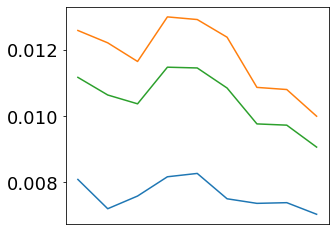

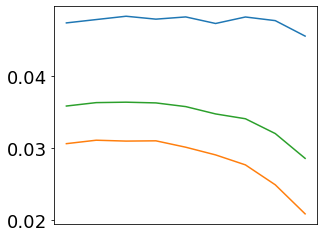

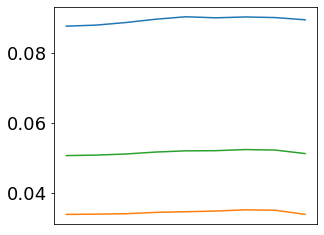

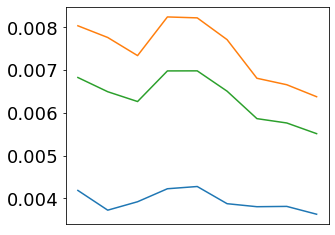

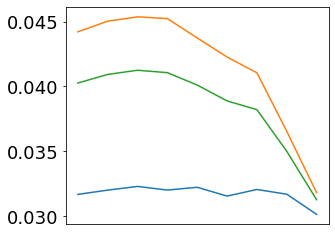

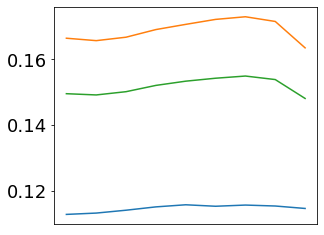

In [76]:
%matplotlib inline
plt.rcParams['font.size'] = 18
# selected_metrics = list(metric_results.keys())
# selected_metrics = ['P@10','RECALL@10', 'AUC']
# selected_metrics = [f'RECALL@{k}' for k in [1,10,50]]
# selected_metrics = [f'F1@{k}' for k in [1,10,50]]
# selected_metrics = ['F1@50']
for m in [f'{m_name}@{k}' for m_name in ['F1','RECALL'] for k in [1,10,50]]:
    selected_metrics = [m]
    plot_multiple_line(metric_results, selected_metrics, x_ticks = sorted_lambda, 
                       no_title = True, no_xticks = True,
                       ncol = 3, ylabel = '', xlabel = '', 
                       legend_title = 'activity', legend_appear_at = -1)
#     plot_multiple_line(metric_results, selected_metrics, x_ticks = sorted_lambda, 
#                        ncol = 3, ylabel = '', xlabel = '', 
#                        legend_title = 'activity', legend_appear_at = -1)

### 2. Performance Distribution

In [25]:
import numpy as np
from tqdm import tqdm
pick_column = {'model_name': }
label = '-'.join([df[pick_column].iloc[i] for i in range(4)])
group_metrics = {G: {} for G in groups}
for G in tqdm(groups):
    subset = df.loc[df[1] == G]
    group_metrics[G][label] = [float(v) for v in subset[pick_column].values if float(v) > 0]

100%|██████████| 2/2 [00:00<00:00, 251.61it/s]


/home/sl1471/anaconda3/envs/bmrl/lib/python3.9/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/sl1471/anaconda3/envs/bmrl/lib/python3.9/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/sl1471/anaconda3/envs/bmrl/lib/python3.9/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg,

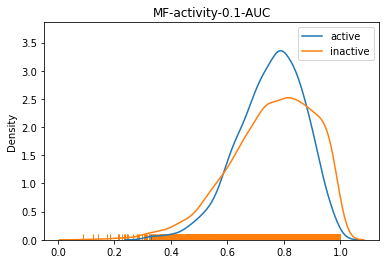

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

for G in groups:
    ax = sns.distplot(group_metrics[G][label], rug=True, hist=False, label = G)
#     sns.histplot(data=group_metrics[G][label], x = G, kde=True)
#     plt.hist(group_metrics[G][label], 50, density = True, label = G)
plt.title(label)
plt.legend()
plt.show()